In [ ]:
#face-age estimator

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Dataset class for UTKFace
class UTKFaceDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_paths = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        filename = os.path.basename(img_path)
        
        # Extract age from filename (e.g., "25_0_0_20170113133222752.jpg")
        age = int(filename.split("_")[0])
        
        # Load image
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(age, dtype=torch.float32)

# Transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load dataset
data_dir = "./UTKFace/UTKFace"
dataset = UTKFaceDataset(data_dir=data_dir, transform=transform)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class AgeEstimatorCNN(nn.Module):
    def __init__(self):
        super(AgeEstimatorCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 1)  # Single output for age

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [7]:
from torch.optim import Adam

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AgeEstimatorCNN().to(device)
criterion = nn.MSELoss()  # Mean squared error for regression
optimizer = Adam(model.parameters(), lr=0.001)

from tqdm import tqdm

# Training function with model saving
def train_and_save_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, save_path="age_estimator.pth"):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
        for images, ages in progress_bar:
            images, ages = images.to(device), ages.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs.squeeze(), ages)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            progress_bar.set_postfix(loss=loss.item())
        
        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, ages in val_loader:
                images, ages = images.to(device), ages.to(device)
                outputs = model(images)
                loss = criterion(outputs.squeeze(), ages)
                val_loss += loss.item() * images.size(0)
        
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # Save the model (overwrites previous)
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

# Train and save the model
train_and_save_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch 1/10: 100%|██████████| 593/593 [01:40<00:00,  5.88batch/s, loss=129]  


Epoch 1/10 - Train Loss: 226.8864, Val Loss: 153.6397
Model saved to age_estimator.pth


Epoch 2/10: 100%|██████████| 593/593 [01:40<00:00,  5.91batch/s, loss=81.1]


Epoch 2/10 - Train Loss: 133.5854, Val Loss: 122.0962
Model saved to age_estimator.pth


Epoch 3/10: 100%|██████████| 593/593 [01:36<00:00,  6.17batch/s, loss=191] 


Epoch 3/10 - Train Loss: 101.1519, Val Loss: 149.5458
Model saved to age_estimator.pth


Epoch 4/10: 100%|██████████| 593/593 [01:35<00:00,  6.18batch/s, loss=52.8]


Epoch 4/10 - Train Loss: 80.7328, Val Loss: 88.7090
Model saved to age_estimator.pth


Epoch 5/10: 100%|██████████| 593/593 [01:36<00:00,  6.18batch/s, loss=73.8]


Epoch 5/10 - Train Loss: 66.0834, Val Loss: 92.0900
Model saved to age_estimator.pth


Epoch 6/10: 100%|██████████| 593/593 [01:36<00:00,  6.16batch/s, loss=54.6]


Epoch 6/10 - Train Loss: 56.8065, Val Loss: 85.5458
Model saved to age_estimator.pth


Epoch 7/10: 100%|██████████| 593/593 [01:36<00:00,  6.17batch/s, loss=60.6]


Epoch 7/10 - Train Loss: 46.1983, Val Loss: 90.3975
Model saved to age_estimator.pth


Epoch 8/10: 100%|██████████| 593/593 [01:35<00:00,  6.19batch/s, loss=50.3]


Epoch 8/10 - Train Loss: 37.3525, Val Loss: 85.1032
Model saved to age_estimator.pth


Epoch 9/10: 100%|██████████| 593/593 [01:35<00:00,  6.18batch/s, loss=27.5]


Epoch 9/10 - Train Loss: 31.0364, Val Loss: 85.1327
Model saved to age_estimator.pth


Epoch 10/10: 100%|██████████| 593/593 [01:35<00:00,  6.18batch/s, loss=26.2]


Epoch 10/10 - Train Loss: 25.5568, Val Loss: 95.1540
Model saved to age_estimator.pth


C:\Users\Hunter Rogers\AppData\Local\Temp\ipykernel_20448\712869647.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


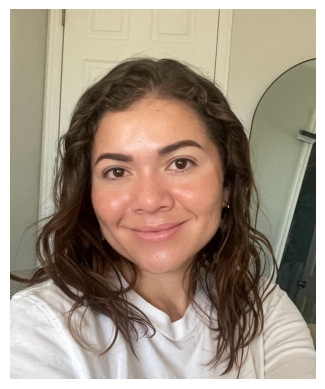

Predicted Age: 18.69 years


In [12]:
from torchvision import transforms
from PIL import Image
import torch
import matplotlib.pyplot as plt

def predict_age(model, image_path, device):
    # Transform the image
    transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Same size as training
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Same normalization
    ])
    
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    
    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
    
    # Output is the predicted age
    predicted_age = output.item()  # Convert tensor to scalar
    return predicted_age

# Example usage
image_path = "./to_predict/smile_gisell.jpg"  # Path to the new image
model_path = "./age_estimator.pth"  # Path to the saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model (if saved previously)
model = AgeEstimatorCNN().to(device)
model.load_state_dict(torch.load(model_path))

# Predict age
predicted_age = predict_age(model, image_path, device)
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Optional: Hide axes
plt.show()
print(f"Predicted Age: {predicted_age:.2f} years")
